In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# K-Means Clustering

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Load data
df = pd.read_csv('/content/drive/MyDrive/BDM Capstone/combined_files.csv')

# Convert 'BillDate' to datetime
df['BillDate'] = pd.to_datetime(df['BillDate'], dayfirst=True)

# Creating loyalty features
df['YearMonth'] = df['BillDate'].dt.to_period('M')
monthly_spending = df.groupby(['CustomerCode', 'YearMonth']).agg({'Profit': 'sum'}).reset_index()
frequency = monthly_spending.groupby('CustomerCode').size().reset_index(name='Frequency')
total_spend = df.groupby('CustomerCode')['Profit'].sum().reset_index()
first_last_visit = df.groupby('CustomerCode')['BillDate'].agg(first_visit='min', last_visit='max').reset_index()
first_last_visit['Longevity'] = (first_last_visit['last_visit'] - first_last_visit['first_visit']).dt.days

# Merging features
loyalty_df = pd.merge(frequency, total_spend, on='CustomerCode')
loyalty_df = pd.merge(loyalty_df, first_last_visit[['CustomerCode', 'Longevity']], on='CustomerCode')

# Prioritize EXISTING over NEW for each customer
# If a customer is tagged as both NEW and EXISTING, we will retain 'EXISTING'
df['New customer Type'] = df['New customer Type'].map({'NEW': 0, 'EXISTING': 1})

# Group by CustomerCode to ensure 'EXISTING' (1) is retained if it exists
df_priority = df.groupby('CustomerCode')['New customer Type'].max().reset_index()

# Merge the priority customer type into the loyalty_df DataFrame
loyalty_df = pd.merge(loyalty_df, df_priority, on='CustomerCode', how='left')

# Preprocessing
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
features = ['Frequency', 'Profit', 'Longevity', 'New customer Type']
loyalty_df[features] = imputer.fit_transform(loyalty_df[features])
loyalty_df_scaled = scaler.fit_transform(loyalty_df[features])

# Clustering
kmeans = KMeans(3)
loyalty_df['Cluster'] = kmeans.fit_predict(loyalty_df_scaled)

# Analyzing clusters
mean_values = loyalty_df.groupby('Cluster')[['Frequency', 'Profit', 'Longevity', 'New customer Type']].mean()
print(mean_values)
loyalty_df['New customer Type'] = loyalty_df['New customer Type'].map({0: "NEW", 1: "EXISTING"})

# Save or print results
# loyalty_df.to_csv('/content/drive/MyDrive/BDM Capstone/loyalty_clusters.csv', index=False)

         Frequency         Profit   Longevity  New customer Type
Cluster                                                         
0         1.000000    9067.787876    0.000000                0.0
1         5.716981  178623.568784  254.641509                1.0
2         1.389497   20301.292584   23.275711                1.0


In [ ]:
print(loyalty_df['Cluster'].value_counts())

Cluster
0    497
2    457
1     53
Name: count, dtype: int64


# Cluster Plots

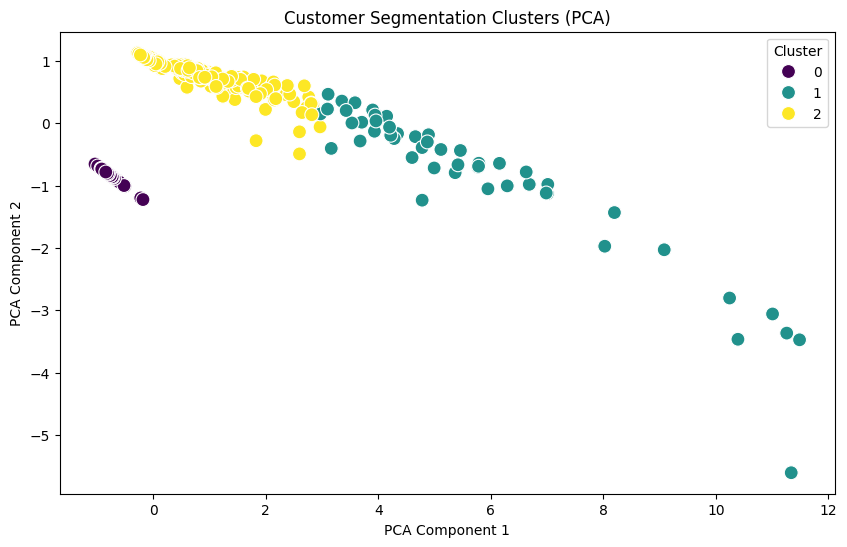

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Apply PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(loyalty_df_scaled)

# Create a DataFrame with the PCA results and clusters
loyalty_df['PCA1'] = pca_components[:, 0]
loyalty_df['PCA2'] = pca_components[:, 1]

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=loyalty_df, palette='viridis', s=100)

# Add plot title and labels
plt.title('Customer Segmentation Clusters (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

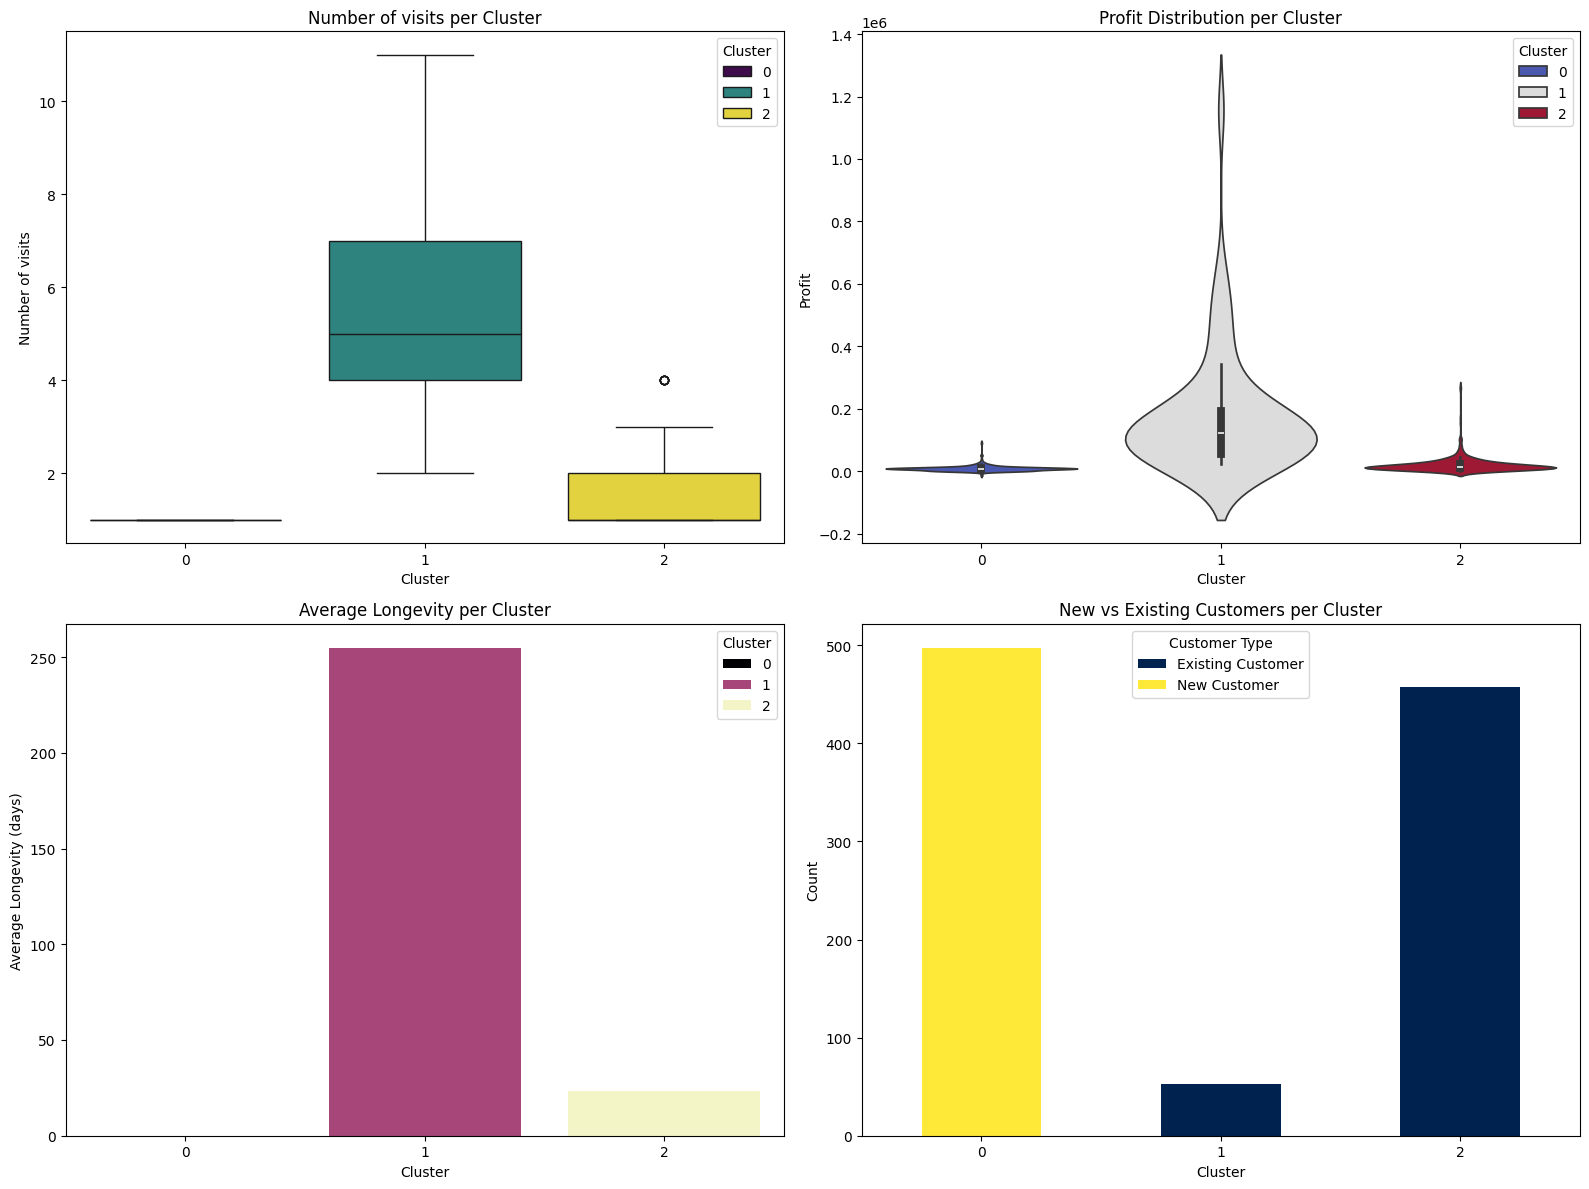

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for multiple plots
plt.figure(figsize=(16, 12))

# 1. Box plot for Frequency across clusters
plt.subplot(2, 2, 1)
sns.boxplot(x='Cluster', y='Frequency', hue='Cluster', data=loyalty_df, palette='viridis')
plt.title('Number of visits per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of visits')

# 2. Violin plot for Profit across clusters
plt.subplot(2, 2, 2)
sns.violinplot(x='Cluster', y='Profit', hue='Cluster', data=loyalty_df, palette='coolwarm')
plt.title('Profit Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Profit')

# 3. Bar plot for Longevity (average) across clusters
plt.subplot(2, 2, 3)
avg_longevity = loyalty_df.groupby('Cluster')['Longevity'].mean().reset_index()
sns.barplot(x='Cluster', y='Longevity', hue='Cluster',data=avg_longevity, palette='magma')
plt.title('Average Longevity per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Longevity (days)')

# 4. Stacked bar plot for New vs Existing Customers across clusters
plt.subplot(2, 2, 4)
new_existing = loyalty_df.groupby(['Cluster', 'New customer Type']).size().unstack().fillna(0)
new_existing.plot(kind='bar', stacked=True, colormap='cividis', ax=plt.gca())
plt.title('New vs Existing Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend([ 'Existing Customer', 'New Customer'], title='Customer Type')
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()


# Updating Loyalty Scheme

In [ ]:
import pandas as pd

# Load your dataset
file_path = '/content/drive/MyDrive/BDM Capstone/loyalty_clusters.csv'
loyalty_clusters = pd.read_csv(file_path)

In [ ]:
frequency_thresholds_refined = {
    "high": loyalty_clusters["Frequency"].quantile(0.65),
    "medium": loyalty_clusters["Frequency"].quantile(0.35),
}

# Calculate loyalty points based on predefined schema
def refined_frequency_points(frequency):
    if frequency > frequency_thresholds_refined["high"]:
        return 10
    elif frequency > frequency_thresholds_refined["medium"]:
        return 6
    else:
        return 3

loyalty_clusters["FrequencyPointsRefined"] = loyalty_clusters["Frequency"].apply(refined_frequency_points)

loyalty_clusters["ProfitPointsRefined"] = (loyalty_clusters["Profit"] // 150).astype(int)

loyalty_clusters["LongevityPointsRefined"] = (loyalty_clusters["Longevity"] // 75).astype(int)

loyalty_clusters["TotalPointsRefined"] = (
    loyalty_clusters["FrequencyPointsRefined"]
    + loyalty_clusters["ProfitPointsRefined"]
    + loyalty_clusters["LongevityPointsRefined"]
)

# Assign Loyalty Groups
loyalty_clusters["NewGroupRefined"] = pd.qcut(
    loyalty_clusters["TotalPointsRefined"],
    q=[0, 0.06, 0.50, 1.0],
    labels=["Platinum", "Gold", "Silver"]
)

# Compare original distribution with new distribution of Loyalty Groups
original_distribution = loyalty_clusters["Cluster"].value_counts(normalize=True)
new_distribution = loyalty_clusters["NewGroupRefined"].value_counts(normalize=True)

print("Original Cluster Distribution:")
print(original_distribution)

print("\nNew Group Distribution (Refined Schema):")
print(new_distribution)

Original Cluster Distribution:
Cluster
0    0.493545
2    0.445879
1    0.060576
Name: proportion, dtype: float64

New Group Distribution (Refined Schema):
NewGroupRefined
Silver      0.495531
Gold        0.431976
Platinum    0.072493
Name: proportion, dtype: float64


# New Cluster Allotment

In [ ]:
import pandas as pd
loyalty_data = pd.read_csv('/content/drive/MyDrive/BDM Capstone/loyalty_clusters.csv')

# Calculate frequency-based points
frequency_thresholds = [
    loyalty_data['Frequency'].quantile(0.65),  # Medium Frequency upper limit
    loyalty_data['Frequency'].quantile(0.35),  # Low Frequency upper limit
]

def calculate_frequency_points(freq):
    if freq > frequency_thresholds[0]:
        return 10  # High Frequency
    elif freq > frequency_thresholds[1]:
        return 6  # Medium Frequency
    else:
        return 3  # Low Frequency

loyalty_data['Frequency Points'] = loyalty_data['Frequency'].apply(calculate_frequency_points)

# Calculate profit-based points
loyalty_data['Profit Points'] = (loyalty_data['Profit'] // 150).astype(int)

# Calculate longevity-based points
loyalty_data['Longevity Points'] = (loyalty_data['Longevity'] // 75).astype(int)

# Calculate total points
loyalty_data['Loyalty Points'] = (
    loyalty_data['Frequency Points'] +
    loyalty_data['Profit Points'] +
    loyalty_data['Longevity Points']
)


# Calculate percentiles to determine thresholds for loyalty groups
platinum_threshold = loyalty_data['Loyalty Points'].quantile(0.94)  # Top 6%
gold_threshold = loyalty_data['Loyalty Points'].quantile(0.50)      # Next 44%

# Assign loyalty groups
def assign_loyalty_group(points):
    if points > platinum_threshold:
        return 'Platinum'
    elif points > gold_threshold:
        return 'Gold'
    else:
        return 'Silver'

# Apply the function to create a new loyalty group column
loyalty_data['New Loyalty Group'] = loyalty_data['Loyalty Points'].apply(assign_loyalty_group)

# Display the updated data with loyalty groups
loyalty_data.head()

,CustomerCode,Frequency,Profit,Longevity,New customer Type,Cluster,Frequency Points,Profit Points,Longevity Points,Loyalty Points,New Loyalty Group
0,10014,5.0,43371.2156,231.0,EXISTING,1,10,289,3,302,Gold
1,14110,4.0,100746.5318,311.0,EXISTING,1,10,671,4,685,Platinum
2,14408,7.0,191907.3188,332.0,EXISTING,1,10,1279,4,1293,Platinum
3,14415,3.0,36480.3059,160.0,EXISTING,2,10,243,2,255,Gold
4,15342,4.0,46644.0516,286.0,EXISTING,1,10,310,3,323,Gold


In [ ]:
# loyalty_data.drop(columns=['Frequency Points', 'Profit Points', 'Longevity Points'], inplace=True)
loyalty_data['Original Loyalty Group'] = loyalty_data['Cluster'].map({1: 'Platinum', 2: 'Gold', 0: 'Silver'})

loyalty_data.head()

,CustomerCode,Frequency,Profit,Longevity,New customer Type,Cluster,Frequency Points,Profit Points,Longevity Points,Loyalty Points,New Loyalty Group,Original Loyalty Group
0,10014,5.0,43371.2156,231.0,EXISTING,1,10,289,3,302,Gold,Platinum
1,14110,4.0,100746.5318,311.0,EXISTING,1,10,671,4,685,Platinum,Platinum
2,14408,7.0,191907.3188,332.0,EXISTING,1,10,1279,4,1293,Platinum,Platinum
3,14415,3.0,36480.3059,160.0,EXISTING,2,10,243,2,255,Gold,Gold
4,15342,4.0,46644.0516,286.0,EXISTING,1,10,310,3,323,Gold,Platinum


In [ ]:
# Save the updated DataFrame to a CSV file
loyalty_data.to_csv('/content/drive/MyDrive/BDM Capstone/updated_loyalty_clusters.csv', index=False)